<hr style="border: dashed rgb(255,69,0) 1.0px;background-color: rgb(255,69,0);height: 5.0px;"/>

# <center> Classification of Cat and Dog using VGG19 transfer learning model </center>

`Dataset Description`

- **Train (Folder)**: contains 9471 images of cats and dogs
- **Test (Folder)**: contains 4059 images of cats and dogs
- **Sample_Submission.csv**: the format of submission accepted
- **Train.csv**: contains the file name and appropriate category for each image in the train data
- **Test.csv**: contains the file name for each image in the test dataData
- **Evaluation**: The submission will be evaluated using the accuracy metric. One can use Sklearn’s accuracy_score to get a valid score.

- [Hackathon link](https://www.machinehack.com/hackathons/5f05b7e78842ae057f62ece5)
- [Instruction link](https://analyticsindiamag.com/weekend-hackathon-11-who-wins-the-classic-computer-vision-problem/)

In [174]:
%reset -f

In [175]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [176]:
import os
os.chdir(r"/content/gdrive/My Drive/Cat and Dog classification/Notebook/")

In [177]:
# !pip install -r "../requirements.txt"

# Import Library

In [178]:
import numpy as np 
np.random.seed(42)
import random as rn
rn.seed(12345)
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../Data"))

['Sample_Submission.csv', 'Train.csv', 'Test', 'Train', 'Sample_Submission1.csv', 'Sample_Submissionvgg16.csv', 'Sample_SubmissionVGG10_20.csv', 'Sample_Submissionvgg16_rmsprop_10.csv', 'Sample_SubmissionVGG19_rmsprop.csv']


# Prepare Training Data

In [179]:
df=pd.read_csv("../Data/Train.csv")
df.Category=df.Category.astype(str)
df["type"]=df.Category.apply(lambda x: "dog" if x=="1" else "cat")
df.head()

,File_Name,Category,type
0,10846.jpg,1,dog
1,2360.jpg,1,dog
2,17531.jpg,0,cat
3,13254.jpg,1,dog
4,15554.jpg,0,cat


### See Total In count

cat    4747
dog    4724
Name: type, dtype: int64

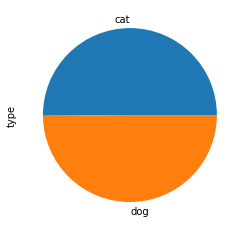

In [180]:
df['type'].value_counts().plot.pie()
df['type'].value_counts()

# See sample image

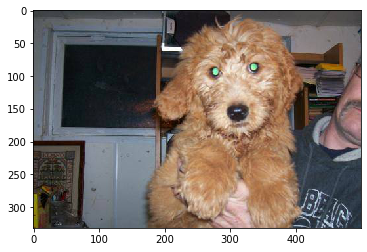

In [181]:
sample = random.choice(list(df.File_Name))
image = load_img("../Data/Train/mixCatDogDataset/"+sample)
plt.imshow(image)

# Build Model

In [182]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG19
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 15
batch_size = 20

pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False 

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",#optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Prepare Test and Train Data

In [183]:
train_df, validate_df = train_test_split(df, test_size=0.1,random_state=42)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

cat    4271
dog    4252
Name: type, dtype: int64

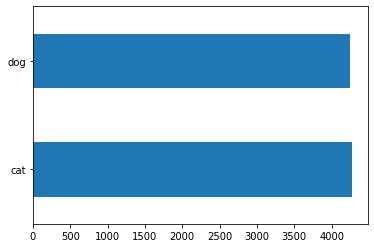

In [184]:
train_df['type'].value_counts().plot.barh()
train_df['type'].value_counts()

cat    476
dog    472
Name: type, dtype: int64

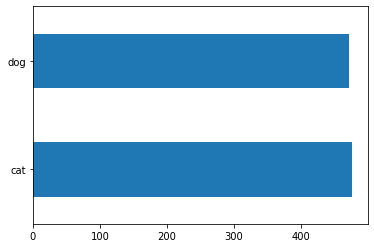

In [185]:
validate_df['type'].value_counts().plot.barh()
validate_df['type'].value_counts()

# Training Generator

In [186]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
) 

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../Data/Train/mixCatDogDataset/", 
    x_col="File_Name",
    y_col="Category",
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 8523 validated image filenames belonging to 2 classes.


# Validation Generator

In [187]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../Data/Train/mixCatDogDataset/", 
    x_col='File_Name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 948 validated image filenames belonging to 2 classes.


# See sample generated images

Found 9 validated image filenames belonging to 2 classes.


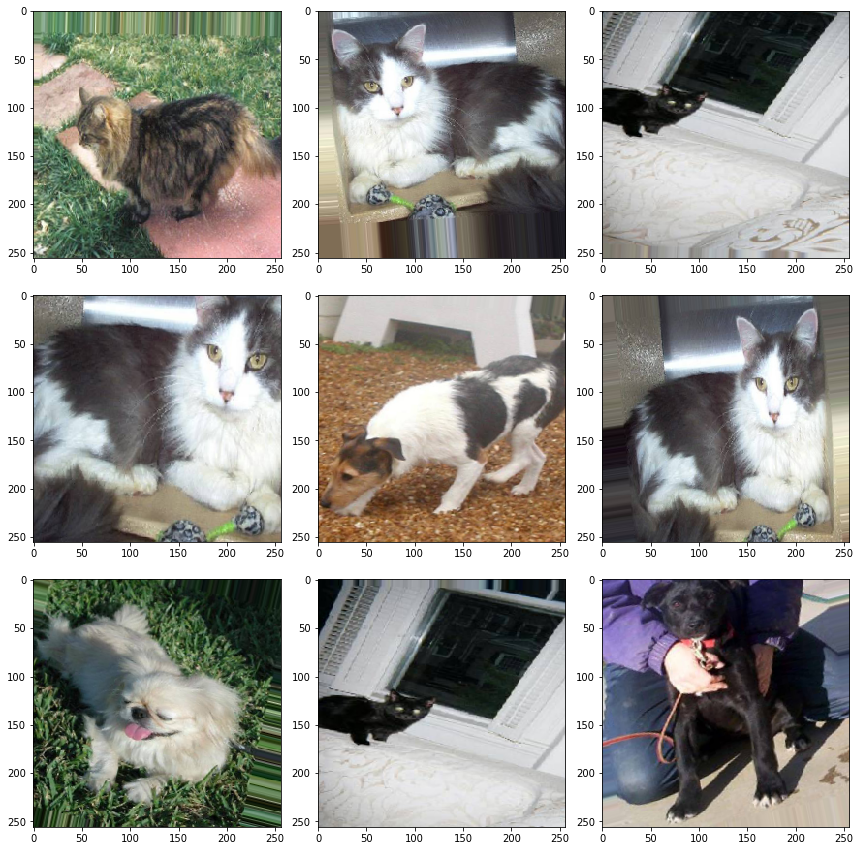

In [188]:
example_df = train_df.sample(n=9).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../Data/Train/mixCatDogDataset/", 
    x_col='File_Name',
    y_col='Category',
    class_mode='binary'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [189]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/15
426/426 [==============================] - 203s 476ms/step - loss: 4.4910 - accuracy: 0.5001 - val_loss: 0.6897 - val_accuracy: 0.4947
Epoch 2/15
426/426 [==============================] - 197s 462ms/step - loss: 0.7566 - accuracy: 0.5881 - val_loss: 0.3886 - val_accuracy: 0.7683
Epoch 3/15
426/426 [==============================] - 200s 470ms/step - loss: 0.5845 - accuracy: 0.7908 - val_loss: 0.2832 - val_accuracy: 0.8879
Epoch 4/15
426/426 [==============================] - 202s 473ms/step - loss: 0.4128 - accuracy: 0.8653 - val_loss: 0.5188 - val_accuracy: 0.8675
Epoch 5/15
426/426 [==============================] - 202s 474ms/step - loss: 0.3698 - accuracy: 0.8846 - val_loss: 0.0754 - val_accuracy: 0.9246
Epoch 6/15
426/426 [==============================] - 201s 471ms/step - loss: 0.3158 - accuracy: 0.9032 - val_loss: 0.0413 - val_accuracy: 0.9192
Epoch 7/15
426/426 [==============================] - 202s 474ms/step - loss: 0.2823 - accuracy: 0.9065 - val_loss: 0.1300 -

In [190]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=6)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.943617  ;  loss = 0.027674 


In [191]:
model.save('../model/model_vgg19_rmsprop.h5')

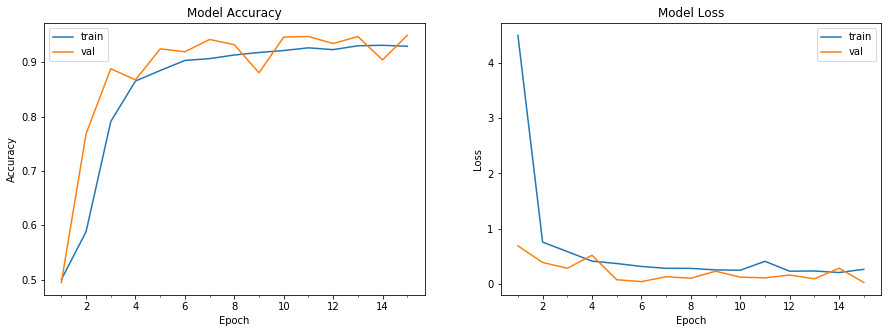

In [192]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [193]:
Y_val = validate_df['Category']
y_pred =  model.predict_generator(validation_generator)

In [194]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [195]:
y_final.size

948

In [196]:
Y_val.size

948

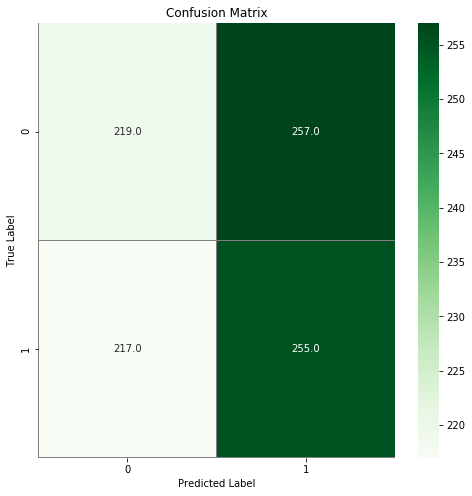

In [197]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, pd.DataFrame(list(y_final.T)).astype(str).T) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [198]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, pd.DataFrame(list(y_final.T)).astype(str).T, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       476
           1       0.50      0.54      0.52       472

    accuracy                           0.50       948
   macro avg       0.50      0.50      0.50       948
weighted avg       0.50      0.50      0.50       948



# Prepare Testing Data

In [199]:
test_filenames = os.listdir("../Data/Test/")
test_df = pd.DataFrame({
    'File_Name': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [200]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../Data/Test/", 
    x_col='File_Name',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 4059 validated image filenames.


# Predict

In [201]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['Category'] = np.where(predict > threshold, 1,0)

# See predicted result

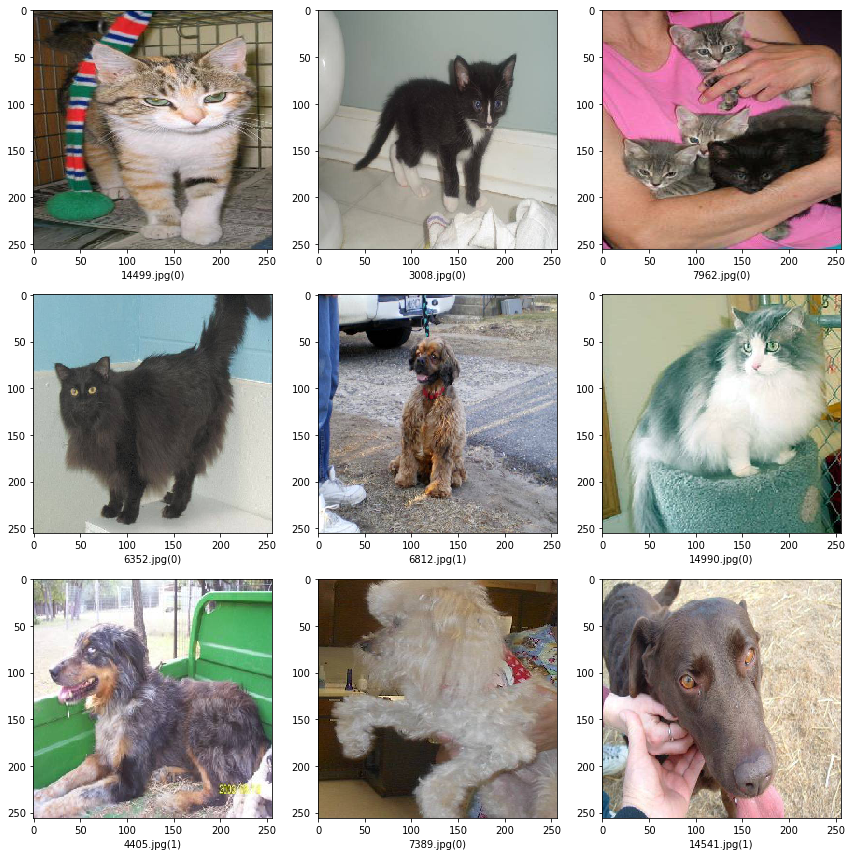

In [202]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['File_Name']
    category = row['Category']
    img = load_img("../Data/Test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

# Submission

Text(0.5, 1.0, '(Test data)')

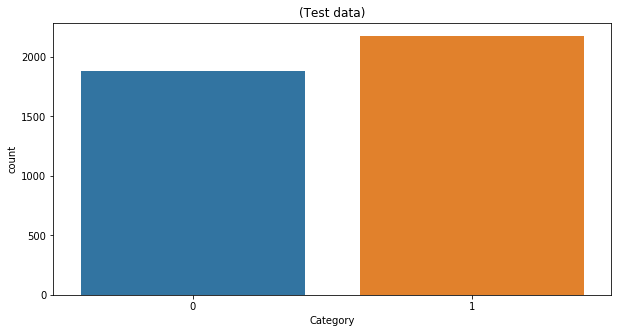

In [203]:
submission_df = test_df.copy()
submission_df.to_csv('../Data/Sample_SubmissionVGG19_rmsprop.csv', index=False)
plt.figure(figsize=(10,5))
sns.countplot(submission_df['Category'])
plt.title("(Test data)")

<div class="copyright"> <span class="pull-right">&#169;</span>Copyright 2020 | <a href="https://www.linkedin.com/in/ashishk766/">Ashish Kumar</a></div>